/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


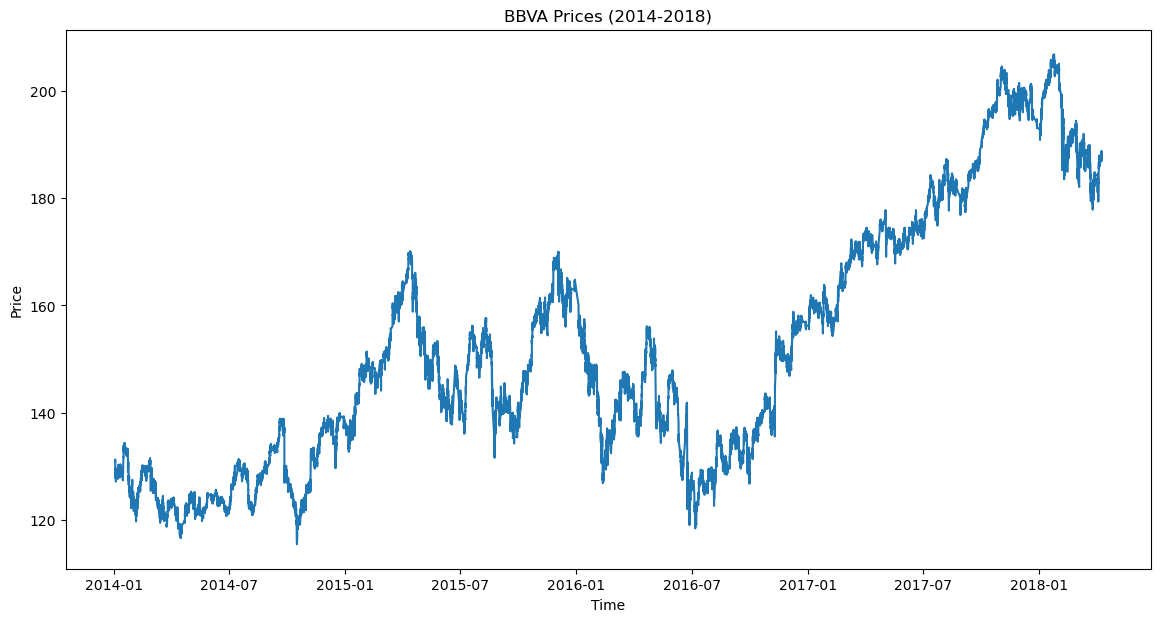

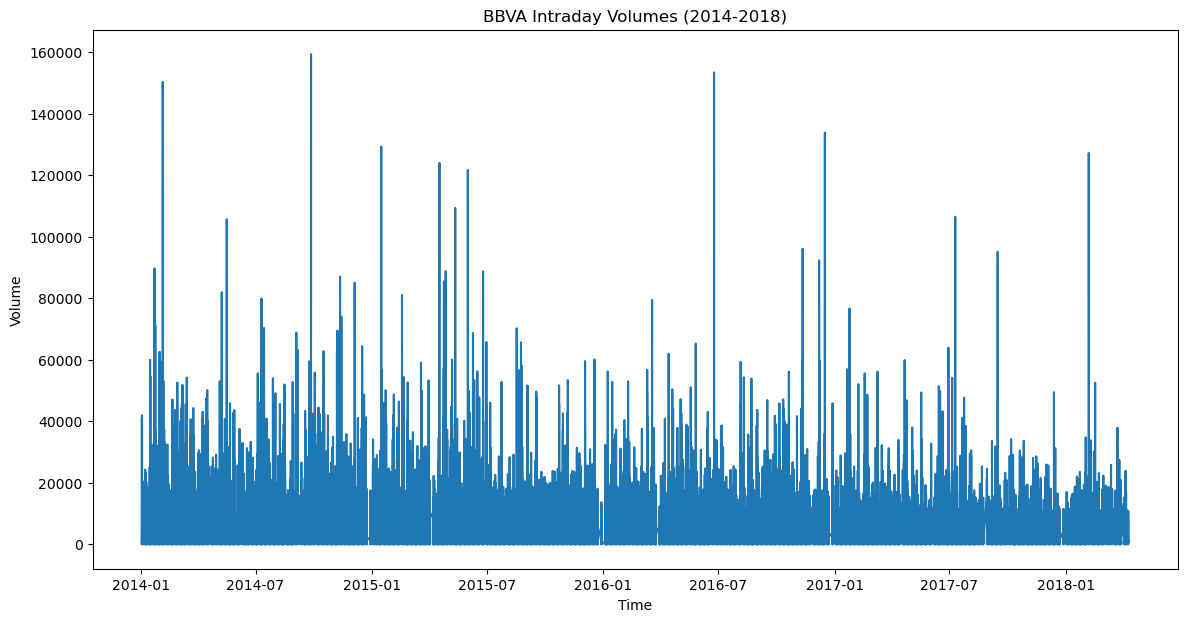

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import yfinance as yf

# Load the dataset
data = pd.read_csv('BBVA_2014_2018_intraday.csv')

# Combine 'date' and 'time' into a single 'Timestamp' column
data['Timestamp'] = pd.to_datetime(data['date'] + ' ' + data['time'])

# Calculate minute-by-minute returns for prices
data['Return'] = data['price'].pct_change()

# Identify overnight gaps
data['Date'] = data['Timestamp'].dt.date
data['Time'] = data['Timestamp'].dt.time
data['Overnight'] = data['Date'].diff().apply(lambda x: x.days > 0 if pd.notnull(x) else False)

# Separate intraday and overnight data
intraday_data = data[~data['Overnight']].copy()
overnight_data = data[data['Overnight']].copy()

# Visualize BBVA Prices and Volumes
plt.figure(figsize=(14, 7))
plt.plot(data['Timestamp'], data['price'])
plt.title('BBVA Prices (2014-2018)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

plt.figure(figsize=(14, 7))
plt.plot(data['Timestamp'], data['volume'])
plt.title('BBVA Intraday Volumes (2014-2018)')
plt.xlabel('Time')
plt.ylabel('Volume')
plt.show()



Random Forest RMSE for Returns: 0.0003520889090967469


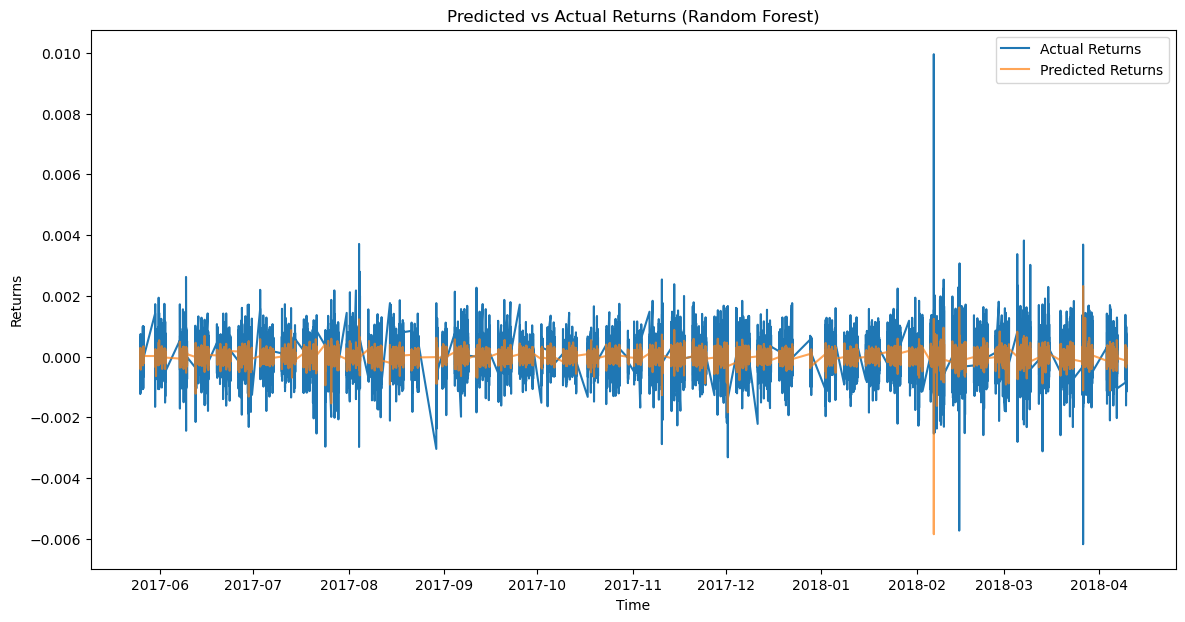

In [2]:
# Feature Engineering: Create lagged returns and volumes as features
for lag in range(1, 6):
    intraday_data[f'Return_Lag_{lag}'] = intraday_data['Return'].shift(lag)
    intraday_data[f'Volume_Lag_{lag}'] = intraday_data['volume'].shift(lag)
intraday_data.dropna(inplace=True)

# **Added Section to Handle Infinite Values**
intraday_data.replace([np.inf, -np.inf], np.nan, inplace=True)
intraday_data.dropna(inplace=True)

# Split data into training and test sets (80% train, 20% test)
train_size = int(len(intraday_data) * 0.8)
train, test = intraday_data[:train_size], intraday_data[train_size:]

# Define features and target for returns
features_returns = [f'Return_Lag_{i}' for i in range(1, 6)]
target_return = 'Return'

# Train Random Forest model for returns
model_rf_returns = RandomForestRegressor()
model_rf_returns.fit(train[features_returns], train[target_return])

# Predict and evaluate returns
predictions_rf_returns = model_rf_returns.predict(test[features_returns])
rmse_rf_returns = np.sqrt(mean_squared_error(test[target_return], predictions_rf_returns))
print(f'Random Forest RMSE for Returns: {rmse_rf_returns}')

# Calculate average return for relative RMSE
avg_return = test[target_return].mean()
relative_rmse_returns = rmse_rf_returns / avg_return


plt.figure(figsize=(14, 7))
plt.plot(test['Timestamp'], test[target_return], label='Actual Returns')
plt.plot(test['Timestamp'], predictions_rf_returns, label='Predicted Returns', alpha=0.7)
plt.title('Predicted vs Actual Returns (Random Forest)')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.show()



Random Forest RMSE for Volumes: 2168.664748276998
Relative RMSE for Volumes: 126.73%


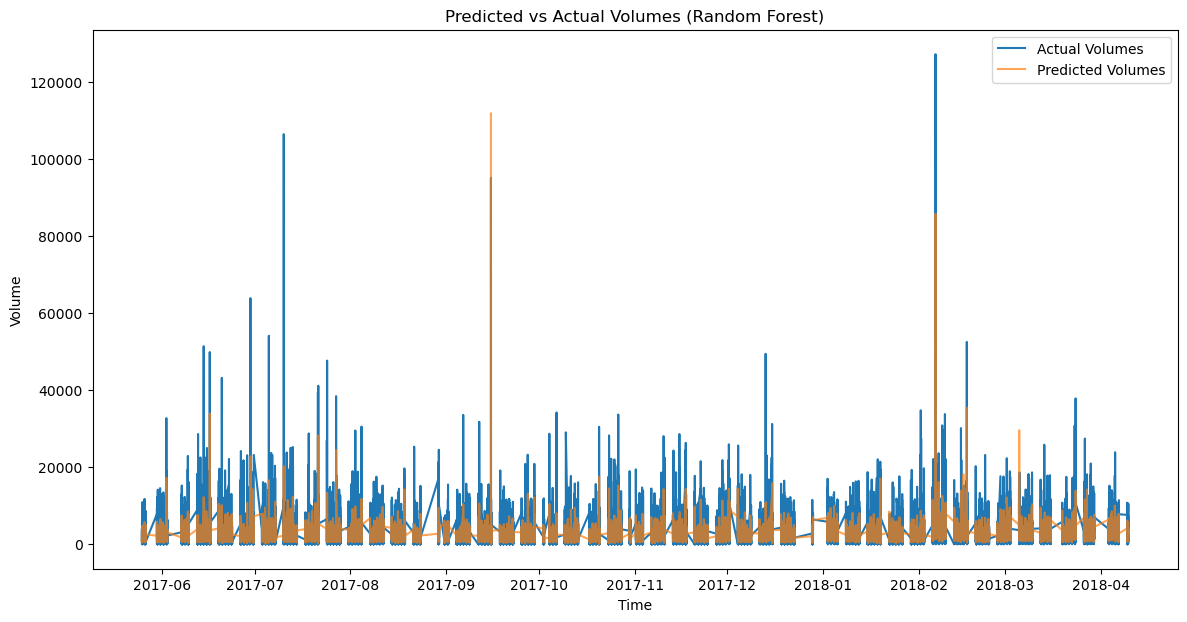

In [3]:
# Define features and target for volumes
features_volumes = [f'Volume_Lag_{i}' for i in range(1, 6)]
target_volume = 'volume'

# Train Random Forest model for volumes
model_rf_volumes = RandomForestRegressor()
model_rf_volumes.fit(train[features_volumes], train[target_volume])

# Predict and evaluate volumes
predictions_rf_volumes = model_rf_volumes.predict(test[features_volumes])
rmse_rf_volumes = np.sqrt(mean_squared_error(test[target_volume], predictions_rf_volumes))
print(f'Random Forest RMSE for Volumes: {rmse_rf_volumes}')

# Calculate average volume for relative RMSE
avg_volume = test[target_volume].mean()
relative_rmse_volumes = rmse_rf_volumes / avg_volume
print(f'Relative RMSE for Volumes: {relative_rmse_volumes * 100:.2f}%')

plt.figure(figsize=(14, 7))
plt.plot(test['Timestamp'], test[target_volume], label='Actual Volumes')
plt.plot(test['Timestamp'], predictions_rf_volumes, label='Predicted Volumes', alpha=0.7)
plt.title('Predicted vs Actual Volumes (Random Forest)')
plt.xlabel('Time')
plt.ylabel('Volume')
plt.legend()
plt.show()



Random Forest RMSE for Returns: 0.0003520889090967469
Random Forest RMSE for Volumes: 2168.664748276998


[*********************100%%**********************]  1 of 1 completed


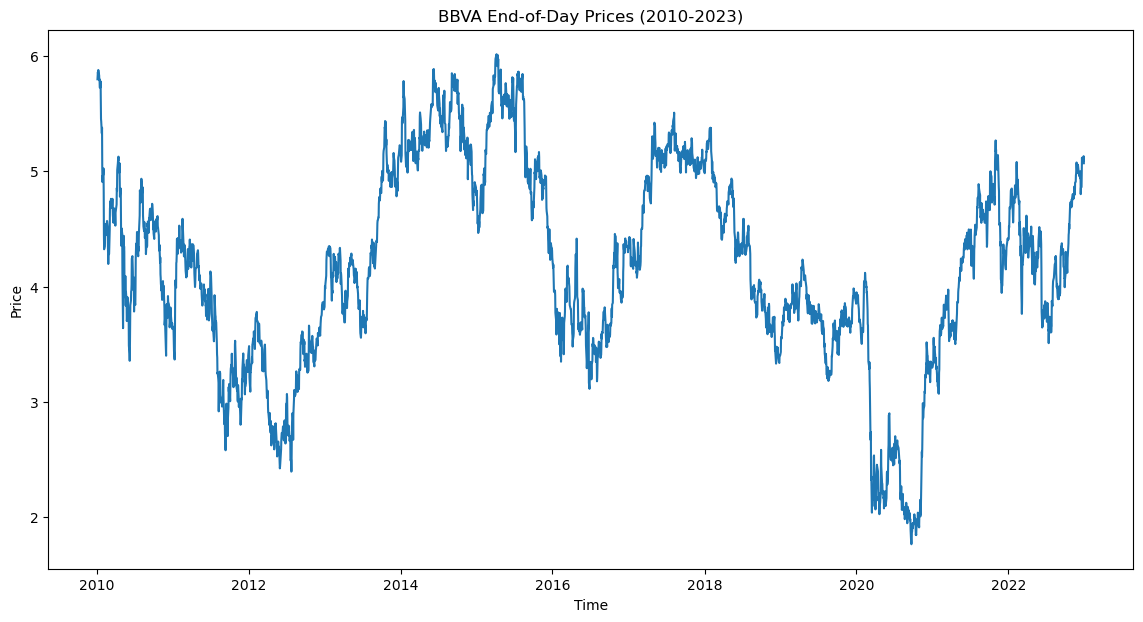

In [4]:
# Comparison of RMSE for returns and volumes
print(f'Random Forest RMSE for Returns: {rmse_rf_returns}')
print(f'Random Forest RMSE for Volumes: {rmse_rf_volumes}')


# Download end-of-day data from Yahoo Finance for extended analysis
bbva = yf.download('BBVA.MC', start='2010-01-01', end='2023-01-01')

# Visualize end-of-day BBVA Prices
plt.figure(figsize=(14, 7))
plt.plot(bbva.index, bbva['Adj Close'])
plt.title('BBVA End-of-Day Prices (2010-2023)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()



Random Forest RMSE for Daily Returns: 0.026517611701582407


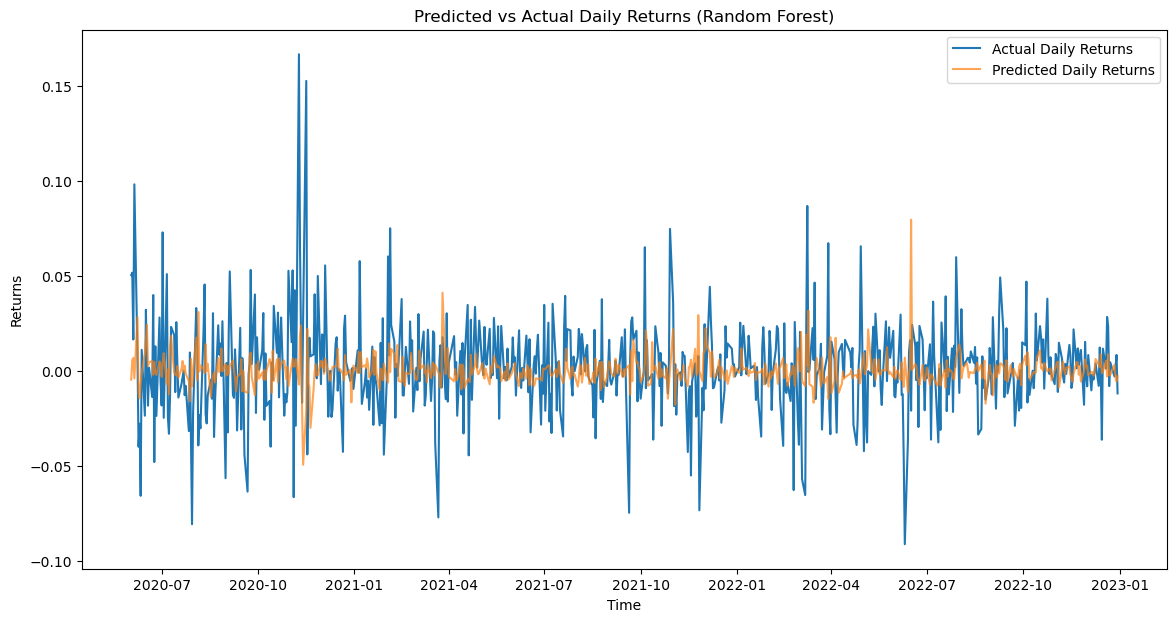

In [5]:
# Calculate daily returns 
bbva['Return'] = bbva['Adj Close'].pct_change()
bbva['Volume'] = bbva['Volume'].pct_change()
bbva.dropna(inplace=True)

# Feature Engineering for Daily Returns and Volumes: Create lagged features
for lag in range(1, 6):
    bbva[f'Return_Lag_{lag}'] = bbva['Return'].shift(lag)
    bbva[f'Volume_Lag_{lag}'] = bbva['Volume'].shift(lag)
bbva.dropna(inplace=True)

# Split daily data into initial training and test sets (80% train, 20% test)
train_size = int(len(bbva) * 0.8)
train, test = bbva[:train_size], bbva[train_size:]

# Define features and targets for daily returns and volumes
features_daily_returns = [f'Return_Lag_{i}' for i in range(1, 6)]
target_daily_return = 'Return'
features_daily_volumes = [f'Volume_Lag_{i}' for i in range(1, 6)]
target_daily_volume = 'Volume'

# Train Random Forest model for daily returns
model_rf_daily_returns = RandomForestRegressor()
model_rf_daily_returns.fit(train[features_daily_returns], train[target_daily_return])

# Predict and evaluate daily returns
predictions_rf_daily_returns = model_rf_daily_returns.predict(test[features_daily_returns])
rmse_rf_daily_returns = np.sqrt(mean_squared_error(test[target_daily_return], predictions_rf_daily_returns))
print(f'Random Forest RMSE for Daily Returns: {rmse_rf_daily_returns}')

# Calculate average daily return for relative RMSE
avg_daily_return = test[target_daily_return].mean()
relative_rmse_daily_returns = rmse_rf_daily_returns / avg_daily_return


plt.figure(figsize=(14, 7))
plt.plot(test.index, test[target_daily_return], label='Actual Daily Returns')
plt.plot(test.index, predictions_rf_daily_returns, label='Predicted Daily Returns', alpha=0.7)
plt.title('Predicted vs Actual Daily Returns (Random Forest)')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.show()

